In [1]:
import os, sys
sys.path.append("../../")
from utils import utils
import numpy as np
import collections
import json

tissue_file = "../../plots/tissue_table.txt"
json_file   = "../../gtex_v8_metadata.json"
tshorts, tfulls, tstrings = utils.read_tissues_str(tissue_file)
with open(json_file) as instream:
    gtex_meta = json.load(instream)
tissue_colors = dict()
tissue_names = dict()
tissue_nsamples = dict()

for tshort, tfull, tstring in zip(tshorts, tfulls, tstrings):
    if tshort in tshorts:
        tissue_names[tshort] = tstring
        tissue_colors[tshort] = "#" + gtex_meta[tfull]["colorHex"]
        tissue_nsamples[tshort] = gtex_meta[tfull]["rnaSeqSampleCount"]
        
brain_tissues = ['bam', 'ban', 'bca', 'bceh', 'bce', 'bco', 'bfr', 'bhi', 'bhy', 'bnu', 'bpu', 'bsp', 'bsu']
altsb_tissues = ['haa', 'pan', 'spl', 'wb']

In [2]:
def read_fst_file(infile):
    fst_dict = dict()
    for i in range(1,23):
        fst_dict[i] = dict()
    with open(infile) as instream:
        next(instream)
        for line in instream:
            arr = line.strip().split("\t")
            if len(arr) < 3:
                continue
            fst_dict[int(arr[0])][int(arr[1])] = float(arr[2])
    return fst_dict

fst_file_1kg = "/cbscratch/franco/from_saikat/EUR-AFR.weir.fst"
fst_1kg = read_fst_file(fst_file_1kg)

In [3]:
fst_file_gtex = "/cbscratch/franco/datasets/gtex_v8/genotypes/vcfs_SHAPEIT2/fst/GTEx_EUR_AFR_fix.weir.fst"
fst_gtex = read_fst_file(fst_file_gtex)

In [4]:
x = list()
y = list()
for i in range(1,23):
    for pos in fst_gtex[i]:
        if fst_1kg[i].get(pos,False):
            x.append(fst_gtex[i][pos])
            y.append(fst_1kg[i][pos])

In [5]:
import matplotlib.pyplot as plt

plt.scatter(x,y)
plt.show()

<Figure size 640x480 with 1 Axes>

In [6]:
SNPRES_FIELDS = ['rsid', 'chrom', 'pos', 'logp', 'maf']
class SNPRes(collections.namedtuple('_SNPRes', SNPRES_FIELDS)):
    __slots__ = ()

def tejaas(filepath):
    res = list()
    with open(filepath, 'r') as mfile:
        next(mfile)
        for line in mfile:
            arr   = line.strip().split("\t")
            rsid  = arr[0]
            #chrom = rsid.split("_")[0][3:]
            chrom = int(arr[1])
            pos   = int(arr[2])
            p     = float(arr[7])
            logp  = np.log10(p) if p!=0 else np.log10(10e-30)
            maf   = float(arr[3])
            res.append(SNPRes(rsid=rsid, chrom=chrom, pos=pos, logp=-logp, maf=maf))
    return res    
    
basename = "protein_coding_lncRNA_{:s}_knn30_cut5e-8"
gammas = ["gamma01", "gamma0006"]

In [7]:
basepath = "/cbscratch/franco/trans-eqtl"

trans_dict = dict()
# for gamma in gammas:
#     config = basename.format(gamma)
#     trans_dict[config] = dict()

#     for tissue in tshorts:
#         tejaas_file = os.path.join(basepath, config, tissue, "trans_eqtls_ldpruned.txt")
#         if not os.path.exists(tejaas_file):
#             print("{:s} has no trans-eqtl results".format(tissue))
#             continue
#         print("Loading ", tissue, end="")
#         transeqtls = tejaas(tejaas_file)
#         if len(transeqtls) > 0:
#             trans_dict[config][tissue] = transeqtls
#             print(" has {:d} trans-eqtls".format(len(transeqtls)))
#         else:
#             trans_dict[config][tissue] = []
#             print(" has 0 trans-eqtls")

for tissue in tshorts:
    if tissue in altsb_tissues:
        config = basename.format(gammas[1])
    else:
        config = basename.format(gammas[0])
    tejaas_file = os.path.join(basepath, config, tissue, "trans_eqtls_ldpruned.txt")
    
    if not os.path.exists(tejaas_file):
        print("{:s} has no trans-eqtl results".format(tissue))
        continue
    print("Loading ", tissue, end="")
    transeqtls = tejaas(tejaas_file)
    if len(transeqtls) > 0:
        trans_dict[tissue] = transeqtls
        print(" has {:d} trans-eqtls".format(len(transeqtls)))
    else:
        trans_dict[tissue] = []
        print(" has 0 trans-eqtls")

Loading  as has 586 trans-eqtls
Loading  av has 463 trans-eqtls
Loading  ag has 184 trans-eqtls
Loading  aa has 1298 trans-eqtls
Loading  ac has 1539 trans-eqtls
Loading  at has 391 trans-eqtls
Loading  bam has 1182 trans-eqtls
Loading  ban has 954 trans-eqtls
Loading  bca has 19 trans-eqtls
Loading  bceh has 128 trans-eqtls
Loading  bce has 40 trans-eqtls
Loading  bco has 64 trans-eqtls
Loading  bfr has 32 trans-eqtls
Loading  bhi has 51 trans-eqtls
Loading  bhy has 83 trans-eqtls
Loading  bnu has 379 trans-eqtls
Loading  bpu has 10 trans-eqtls
Loading  bsp has 61 trans-eqtls
Loading  bsu has 28 trans-eqtls
Loading  br has 505 trans-eqtls
Loading  ebv has 297 trans-eqtls
Loading  fib has 209 trans-eqtls
Loading  cols has 75 trans-eqtls
Loading  colt has 1174 trans-eqtls
Loading  esog has 17 trans-eqtls
Loading  esom has 9 trans-eqtls
Loading  esomu has 20 trans-eqtls
Loading  haa has 64 trans-eqtls
Loading  hlv has 247 trans-eqtls
Loading  kc has 14 trans-eqtls
Loading  liv has 37 tra

In [90]:
gtex_snp_map = dict()
gtex_varid_fst = dict()
snps_list = list()
for i in np.arange(1,23):
    gtex_snp_map[i] = dict()
with open("/cbscratch/franco/datasets/gtex_v8/genotypes/vcfs_SHAPEIT2/0.01/gtex_v8_snpinfo_SHAPEIT2.txt") as instream:
    for line in instream:
        arr = line.strip().split(" ")
        chrom = int(arr[0])
        pos = int(arr[2])
        gtex_snp_map[chrom][pos] = arr[1]
        gtex_varid_fst[arr[1]] = fst_gtex[chrom][pos]
        snps_list.append(arr[1])

In [42]:
fst_teqtl_gtex= dict()
all_fst_teqtl = list()
all_fst_teqtl_1kg = list()

counted = list()
for tissue in tshorts:
    fst_teqtl_gtex[tissue] = list()
    for snp in trans_dict[tissue]:
        if snp.rsid not in counted:
            fst_teqtl_gtex[tissue].append(fst_gtex[snp.chrom][snp.pos])
            all_fst_teqtl.append(fst_gtex[snp.chrom][snp.pos])
            if snp.pos in fst_1kg[snp.chrom]:
                all_fst_teqtl_1kg.append(fst_1kg[snp.chrom][snp.pos])
            counted.append(snp.rsid)

In [43]:
counts, bins = np.histogram(np.array(all_fst_teqtl)[~np.isnan(all_fst_teqtl)], bins=20, range=(0,1))
print(counts, bins)

[1339  330  362  577  870 1165 1567 1675 1759 1666 1478 1376 1168 1032
  851  672  317   62   10    0] [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


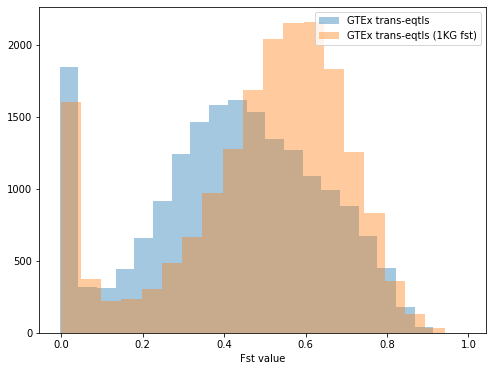

In [45]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
ax1.hist(all_fst_teqtl, bins=20, alpha=0.4, label="GTEx trans-eqtls")
ax1.hist(all_fst_teqtl_1kg, bins=20, alpha=0.4, label="GTEx trans-eqtls (1KG fst)")
ax1.legend(loc='upper right')
ax1.set_xlabel("Fst value")

plt.show()

In [14]:
# Generate the binned list of SNP ids for all GTEx

gtex_fst_bins = collections.defaultdict(list)
bin_width = 0.05
for varid in gtex_varid_fst:
    for b in bins:
        fst_val = gtex_varid_fst[varid]
        if fst_val >= b and fst_val < b+bin_width:
            gtex_fst_bins[np.around(b, 2)].append(varid)
            break

In [28]:
# save them in a json file
with open("gtex_fst_bins.json", 'w') as outf:
    json.dump(gtex_fst_bins, outf)

/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


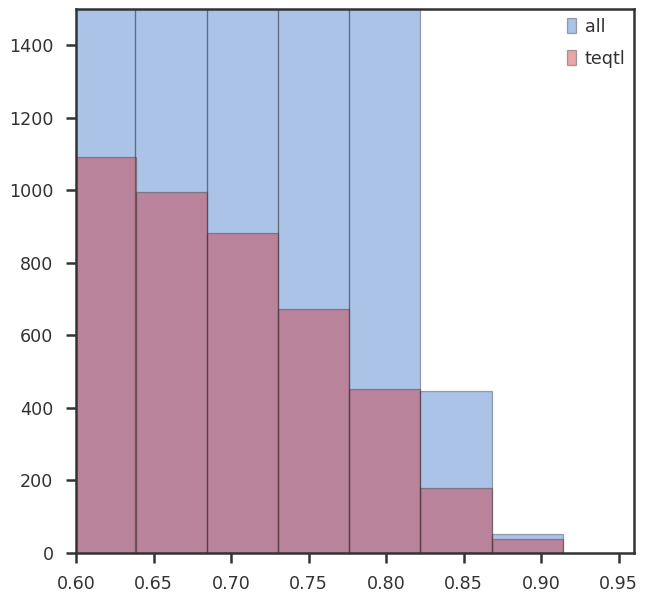

In [114]:
#compare Fst distribution of all gtex to trans-eqtl only fsts
all_gtex_fst = [gtex_varid_fst[x] for x in gtex_varid_fst]
plt.hist(all_gtex_fst, bins=20, alpha=0.4, label="all")
plt.hist(all_fst_teqtl, bins=20, alpha=0.4, label="teqtl")
plt.xlim(0.6,)
plt.ylim(0,1500)
plt.legend()
plt.show()

In [60]:
# save the Fst bins for all trans-eqtls
with open("gtex_teqtl_bininfo.txt", 'w') as outf:
    for i in range(len(counts)):
        outf.write(f"{np.around(bins[i],2)}\t{counts[i]}\n")

In [87]:
def sample_random_fst(snps_list, gtex_fst_bins, fst_distrib):
    hist_range=(0,1)
    bin_w=0.05
    nbins = int(max(hist_range)/bin_w)

    target_distrib_counts, bins = np.histogram(np.array(fst_distrib)[~np.isnan(fst_distrib)], bins=nbins, range=hist_range)
    print(target_distrib_counts, bins)

    res_list = list()
    res_dict = dict()
    for chrm in np.arange(1, 23):
        res_dict[chrm] = list()

    for i,c in enumerate(target_distrib_counts):
        curr_bin = np.around(bins[i],2)
        if c <= 0:
            continue
        if curr_bin not in gtex_fst_bins:
            print(f"Problem! {curr_bin} not in gtex_fst_bins")
            raise
        if c > len(gtex_fst_bins[curr_bin]):
            print("Error, c cannot be larger than available snps in that bin")
            raise
        print(f"sample {c} from {len(gtex_fst_bins[curr_bin])}")
        chooseidx = np.sort(np.random.choice(len(gtex_fst_bins[curr_bin]), c, replace = False))
        for idx in chooseidx:
            var_id = gtex_fst_bins[curr_bin][idx]
            info = var_id.split('_')
            chrm = int(info[0][3:])
            bppos = int(info[1])
            res_dict[chrm].append(bppos)
            res_list.append(var_id)
    return res_dict, res_list

In [115]:
gtex_fst_bins[0.9]

['chr1_1170732_A_G_b38',
 'chr1_159204893_T_C_b38',
 'chr9_344332_T_G_b38',
 'chr9_133904766_G_A_b38',
 'chr15_48108002_A_G_b38',
 'chr15_48134287_A_G_b38',
 'chr15_48141297_A_G_b38',
 'chr15_48193729_T_C_b38',
 'chr19_41914453_T_C_b38',
 'chr21_16556234_A_C_b38']

[1339  330  362  577  870 1165 1567 1675 1759 1666 1478 1376 1168 1032
  851  672  317   62   10    0] [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
sample 1339 from 3483886
sample 330 from 925355
sample 362 from 525135
sample 577 from 387581
sample 870 from 487265
sample 1165 from 428731
sample 1567 from 281637
sample 1675 from 203723
sample 1759 from 139232
sample 1666 from 95747
sample 1478 from 65641
sample 1376 from 42003
sample 1168 from 25935
sample 1032 from 15983
sample 851 from 8287
sample 672 from 3703
sample 317 from 1012
sample 62 from 105
sample 10 from 10


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


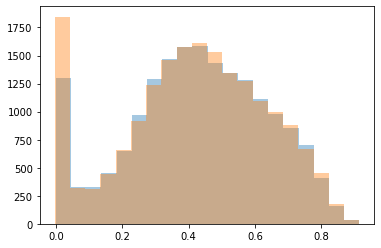

In [92]:
res_dict, res_list = sample_random_fst(snps_list, gtex_fst_bins, all_fst_teqtl)
random_matched_gtex_fst = [gtex_varid_fst[x] for x in res_list]
plt.hist(random_matched_gtex_fst, bins=20, alpha=0.4, label="random matched")
plt.hist(all_fst_teqtl, bins=20, alpha=0.4, label="teqtls")
plt.show()

In [86]:
np.histogram(np.array(random_matched_gtex_fst), range=(0,1), bins=20)

(array([1339,  330,  362,  577,  870, 1165, 1567, 1675, 1759, 1666, 1478,
        1376, 1168, 1032,  851,  672,  317,   62,   10,    0]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]))

In [97]:
import pandas as pd
all_snp_pvals = pd.read_csv(os.path.join("/cbscratch/franco/from_saikat/gtex_v8_202003/all_variants_pvalues_tejaas.txt"), index_col=0, header=0, sep="\t")

In [107]:
np.sort(all_snp_pvals["sse"])

array([-0., -0., -0., ..., nan, nan, nan])

In [100]:
gwfst_gtex = np.array([gtex_varid_fst[x] for x in list(all_snp_pvals.index)])
gwpvals    = np.array(all_snp_pvals["sse"])

/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


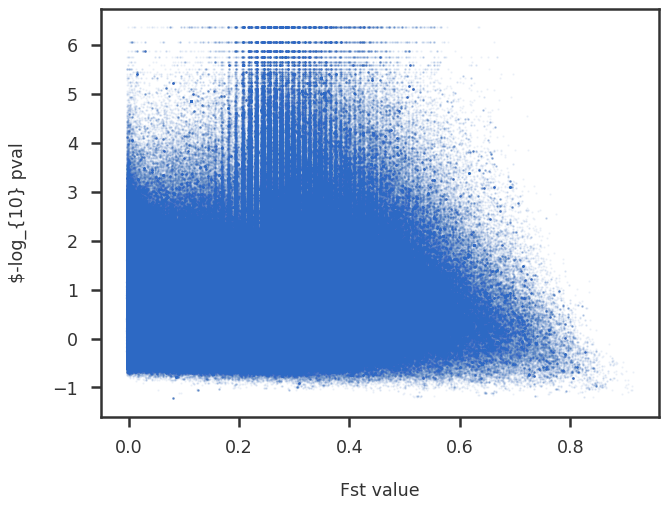

In [118]:
from utils import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 14, colors = 'banskt', dpi = 90)

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
ax1.scatter(gwfst_gtex, -np.log10(gwpvals), alpha=0.05, s=1)
ax1.set_ylabel("$-log_{10} pval")
ax1.set_xlabel("Fst value")
# ax1.set_xlim(0.5, )
plt.show()